Written by Zain Kamal in March 2024 for the Python package `redplanet` (https://github.com/Humboldt-Penguin/redplanet). Feel free to contact me with questions: [zain.eris.kamal@rutgers.edu](mailto:zain.eris.kamal@rutgers.edu).

...

Purpose is to convert a 200m DEM (blend of MGS MOLA and MEX HRSC, linked below) to `zarr.storage.ZipStore` format.
- https://astrogeology.usgs.gov/search/map/mars_mgs_mola_mex_hrsc_blended_dem_global_200m

---
---
# README

In [1]:
# readme_text = '''

# NOTE: YOU DO NOT NEED TO UNZIP A `.zarr.zip` FILE TO ACCESS THE DATA — the original zipped file is perfectly usable on its own, and unzipping will just take up more space on your computer. If you're curious about the reasoning, read the bullet points below. 
#     - One of the storage classes for Zarr arrays/groups is a `zarr.storage.ZipStore` (https://zarr.readthedocs.io/en/stable/api/storage.html#zarr.storage.ZipStore) which does NOT compress files by default (you can verify this for yourself by unzipping and comparing file sizes). This is very similar to how '.tar' files work, if you're familiar. 
#     - We use zipstores because (1) `redplanet` downloads data with `pooch.retrieve` which can only download one file at a time and must always keep the zipped version, and (2) accessing zipstores for a dataset of this size/type/structure has near-zero performance impact compared to a normal Zarr directory. 


# To load this data, use the following code:

#     ```python

#     import xarray as xr
#     import rioxarray    ## optional to attribute/use CRS info -- if you remove this, also remove the `rio.write_crs` lines below.

#     dat_dem_xr = xr.open_zarr('Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2.zarr.zip')  ## specify path as necessary

#     ## Note that `xarray.open_zarr` returns an `xarray.Dataset`. The first data variable ('Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2') is the desired DEM data, and the second data variable ('spatial_ref') is the CRS info from reprojection. We want our final data as an `xarray.DataArray`, and we want to move the 'spatial_ref' to coordinate for rioxarray compliance.
#     dat_dem_xr = (
#         dat_dem_xr
#         .Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2
#         .rio.write_crs(
#             dat_dem_xr.spatial_ref.crs_wkt
#         )
#     )

#     _ = dat_dem_xr.attrs.pop('grid_mapping', None)

#     ```
# '''



In [ ]:
readme_text = '''
'''

---
---
# [0] Setup

In [2]:
from redplanet import utils

from pathlib import Path
import zipfile

import pooch

import numpy as np
# import pandas as pd
# import pyshtools as pysh

import xarray as xr
import rioxarray
import zarr
# import dask


---
---
# [1] Make Zarr Zipstore

In [3]:
''' —————————— Input DEM path (must be local, see above for link) —————————— '''

fpath_dem_tif = Path(r'C:\Users\Eris\AppData\Local\redplanet\redplanet\Cache\Crust\topo\Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2.tif')

# if pooch.file_hash(fpath_custom_DEM_200, alg='sha256') != 'e8bfe4c3b9dee9d5fdb8c4d49798869654e552e7b154712c9e12d6d117464419':
#     raise ValueError('WARNING: File hash does not match. You may be using the wrong file, or the file has been modified. Consider trying to download the file again.')




''' ————————————————————— Load DEM (chunked with dask) ————————————————————— '''

dat_dem_xr = (
    rioxarray.open_rasterio(
        filename = fpath_dem_tif, 
        chunks   = {'x': 'auto', 'y': 'auto'}, 
    )
    .sel(band=1).drop_vars(['band'])
    .rename({'x': 'lon', 'y': 'lat'})
    .sortby('lat', ascending=True)
    .chunk({'lon': 'auto', 'lat': 'auto'})
    .rename('Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2')
)

dat_dem_xr.attrs = {
    'units'    : 'meters', 
    'metadata' : {
        'source_data' : 'https://astrogeology.usgs.gov/search/map/Mars/Topography/HRSC_MOLA_Blend/Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2', 
        'source_code' : 'https://github.com/Humboldt-Penguin/redplanet/blob/main/docs/development/public/Crust/generate_DEM-200m_zarr-zipstore.ipynb', 
        'description' : "For description of modifications and source code, see the source code or 'Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2.zarr/_README.txt' (you can open the file without unzipping everything)."
    },  
}

print(f'CRS info (unchanged from source TIF):\n')
utils.print_dict(dat_dem_xr.spatial_ref.attrs)
print()
print(f'xarray.DataArray string repr:\n{dat_dem_xr}')
print()
print(f'xarray.DataArray html repr (may not fully render in Github):\n')
dat_dem_xr

CRS info (unchanged from source TIF):

'crs_wkt'
	'GEOGCS["GCS_Mars_2000_Sphere",DATUM["Mars_2000_(Sphere)",SPHEROID["Mars_2000_Sphere_IAU_IAG",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'
'semi_major_axis'
	3396190.0
'semi_minor_axis'
	3396190.0
'inverse_flattening'
	0.0
'reference_ellipsoid_name'
	'Mars_2000_Sphere_IAU_IAG'
'longitude_of_prime_meridian'
	0.0
'prime_meridian_name'
	'Reference_Meridian'
'geographic_crs_name'
	'GCS_Mars_2000_Sphere'
'horizontal_datum_name'
	'Mars_2000_(Sphere)'
'grid_mapping_name'
	'latitude_longitude'
'spatial_ref'
	'GEOGCS["GCS_Mars_2000_Sphere",DATUM["Mars_2000_(Sphere)",SPHEROID["Mars_2000_Sphere_IAU_IAG",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'
'GeoTransform'
	'-180.0 0.003374120830641 0.0 90.0 0.0 -0.003374120830641'

xarray.DataArray st

<xarray.DataArray 'Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2' (lat: 53347,
                                                             lon: 106694)> Size: 11GB
dask.array<rechunk-merge, shape=(53347, 106694), dtype=int16, chunksize=(8192, 8192), chunktype=numpy.ndarray>
Coordinates:
  * lon          (lon) float64 854kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat          (lat) float64 427kB -90.0 -89.99 -89.99 ... 89.99 89.99 90.0
    spatial_ref  int32 4B 0
Attributes:
    units:     meters
    metadata:  {'source_data': 'https://astrogeology.usgs.gov/search/map/Mars...

In [4]:
''' ———————————————————— Write Zarr ZipStore and README ———————————————————— '''

fpath_dem_zarrzip = pooch.os_cache('redplanet') / 'Crust' / 'topo' / 'Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2.zarr.zip'

with zarr.ZipStore(fpath_dem_zarrzip, mode='w') as zipstore:
    dat_dem_xr.to_zarr(store=zipstore)

with zipfile.ZipFile(fpath_dem_zarrzip, 'a') as zipf:
    zipf.writestr('_README.txt', readme_text)


In [5]:
''' ——————————————————————————— hashes for pooch ——————————————————————————— '''

print(f"xxh3_64:{pooch.file_hash(fpath_dem_zarrzip, alg='xxh3_64')}")
print(f"sha256:{ pooch.file_hash(fpath_dem_zarrzip, alg='sha256' )}")
print(f"md5:{    pooch.file_hash(fpath_dem_zarrzip, alg='md5'    )}")

xxh3_64:a7a929b9ba7c7e96
sha256:3710fcc91a32ac5d1f8b04e382d20645e419a968faf7a9c34c8bbe8808201a39
md5:0a9b2364d4d9dc80fc6e0534296bc501


Proper hashes:
- xxh3_64:a7a929b9ba7c7e96
- sha256:3710fcc91a32ac5d1f8b04e382d20645e419a968faf7a9c34c8bbe8808201a39
- md5:0a9b2364d4d9dc80fc6e0534296bc501

---
---
# [2] Verify

In [6]:
''' ———————————————————————————— load to xarray ———————————————————————————— '''

fpath_dem_zarrzip = pooch.os_cache('redplanet') / 'Crust' / 'topo' / 'Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2.zarr.zip'

dat_dem_xr = xr.open_zarr(fpath_dem_zarrzip)

## The following line is needed since `xarray.open_zarr` returns an `xarray.Dataset`. The first data variable 'Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2' is the desired DEM data, but the other data variable 'spatial_ref' is the CRS info from reprojection. We want our final data as an `xarray.DataArray` for convenience, and we want to move the 'spatial_ref' to coordinate for rioxarray compliance.
dat_dem_xr = (
    dat_dem_xr
    .Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2
    .rio.write_crs(
        dat_dem_xr.spatial_ref.crs_wkt
    )
)

_ = dat_dem_xr.attrs.pop('grid_mapping', None)

dat_dem_xr

<xarray.DataArray 'Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2' (lat: 53347,
                                                             lon: 106694)> Size: 11GB
dask.array<open_dataset-Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2, shape=(53347, 106694), dtype=int16, chunksize=(8192, 8192), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float64 427kB -90.0 -89.99 -89.99 ... 89.99 89.99 90.0
  * lon          (lon) float64 854kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
    spatial_ref  int32 4B 0
Attributes:
    metadata:  {'description': "For description of modifications and source c...
    units:     meters

region.mean().values.item() = -720.7675211572935
region.values.shape = (53347,106694)


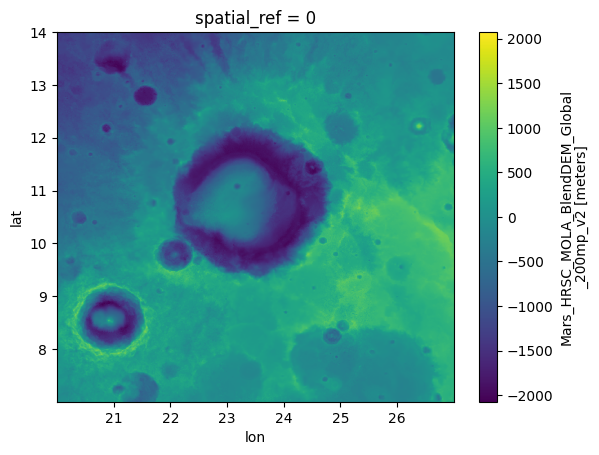

In [7]:
''' —————————————————————————————— test access ————————————————————————————— '''

lon_bounds = (-180, 180)
lat_bounds = (-90, 90)

grid_spacing = 0        # native res

if grid_spacing == 0:
    region = dat_dem_xr.sel(
        lon = slice( lon_bounds[0], lon_bounds[1] ), 
        lat = slice( lat_bounds[0], lat_bounds[1] ),
    )
else:
    region = dat_dem_xr.sel(
        lon = np.arange( lon_bounds[0], lon_bounds[1], grid_spacing ), 
        lat = np.arange( lat_bounds[0], lat_bounds[1], grid_spacing ), 
        method = 'nearest',
    )


print(f'{region.mean().values.item() = }')
# print(f'{region.values.shape = }')    ## don't do this lol it takes a few minutes and lags like crazy — the final shape is (53347, 106694) if you're curious, but you can just check the lon/lat dim sizes
print(f'region.values.shape = ({region.lat.values.shape[0]},{region.lon.values.shape[0]})')




''' ——————————————————————————————— test plot —————————————————————————————— '''

lon_bounds = (20, 27)
lat_bounds = (7, 14)

grid_spacing = 0        # native res

if grid_spacing == 0:
    region = dat_dem_xr.sel(
        lon = slice( lon_bounds[0], lon_bounds[1] ), 
        lat = slice( lat_bounds[0], lat_bounds[1] ),
    )
else:
    region = dat_dem_xr.sel(
        lon = np.arange( lon_bounds[0], lon_bounds[1], grid_spacing ), 
        lat = np.arange( lat_bounds[0], lat_bounds[1], grid_spacing ), 
        method = 'nearest',
    )


region.plot.imshow(cmap='viridis')